## **ONLINE stage**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2901/3115343983.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2901/3115343983.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### MATRICES LOADING

In [2]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]

#### SELECTION OF THE FULL ORDER PARAMETERS 

In [3]:
TIME_DELTA = 10000
#FISSION_RATE = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(1))
FISSION_RATE = 3e19
FISSION_ENERGY = 3.215E-11                      #[J/fissions]
FUEL_DENSITY = 11040                            # rho [Kg/m^3]
FUEL_SPECIFIC_HEAT = 400                        #Cp [J/(Kg K)]
POWER_DENSITY = FISSION_ENERGY * FISSION_RATE   #q''' [W/m^3]
FISSION_HEAT = FISSION_ENERGY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)    #[K/fissions] = Energia di fissione/(rho Cp)
FISSION_YIELD = 0.24E+00                
SOURCE_T = POWER_DENSITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)   #[K/s] = q'''/(rho Cp)   
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
FUEL_THERMAL_CONDUCTIVITY = 2.208                                      #[W/(m K)]
ALPHA_T = FUEL_THERMAL_CONDUCTIVITY/(FUEL_DENSITY*FUEL_SPECIFIC_HEAT)  # [m^2 / s]        # = k/(rho Cp)
#LENGTH = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(1))
LENGTH = 1e-03
#RADIUS = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(1))
RADIUS = 1e-05
#T_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(1))
T_BC = 2000
print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "f/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m")
print("The selected Fission Yield is", FISSION_YIELD, "at/fiss")
print("The selected Power Density q''' is", POWER_DENSITY, "W/m^3")
print("The selected Fuel Density is",FUEL_DENSITY, "kg/m^3")
print("The selected Fuel Specific Heat Cp is", FUEL_SPECIFIC_HEAT, "J/(kg K)")
print("The selected Fuel Therma Conductivity k is", FUEL_THERMAL_CONDUCTIVITY, "W/(m K)\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 f/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m
The selected Fission Yield is 0.24 at/fiss
The selected Power Density q''' is 964500000.0 W/m^3
The selected Fuel Density is 11040 kg/m^3
The selected Fuel Specific Heat Cp is 400 J/(kg K)
The selected Fuel Therma Conductivity k is 2.208 W/(m K)



#### CONSTRUCTION OF THE LHS AND RHS

In [4]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

### FORWARD EULER

In [5]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

6.540057459830545e+22
1.2768664470801436e+23
1.8765020468746513e+23
2.4570692735053178e+23
3.021145416014656e+23
3.570530195331811e+23
4.106578285485807e+23
4.6303588426516404e+23
5.1427433626535236e+23
5.6444594855412486e+23
6.136126410523988e+23
6.618279353550543e+23
7.091387023363942e+23
7.555864445979233e+23
8.012082590247452e+23
8.460375738223554e+23
8.9010472314307e+23
9.33437402469112e+23
9.760610348584163e+23
1.0179990694288602e+24
1.0592732275180316e+24
1.0999037078503564e+24
1.139909359160966e+24
1.1793078266708316e+24
1.2181156773207483e+24
1.256348507579991e+24
1.2940210368324132e+24
1.3311471887291355e+24
1.36774016242785e+24
1.403812495275858e+24
1.4393761182100754e+24
1.4744424049230003e+24
1.5090222156646804e+24
1.543125936406949e+24
1.576763513979559e+24
1.6099444876927468e+24
1.6426780178826292e+24
1.6749729117512974e+24
1.7068376468198924e+24
1.7382803922682454e+24
1.7693090283971435e+24
1.7999311644177383e+24
1.8301541547458998e+24
1.8599851139566857e+24
1.889430930

#### COMPARISON WITH THE FULL ORDER MODEL

1.0950857119086364e-05


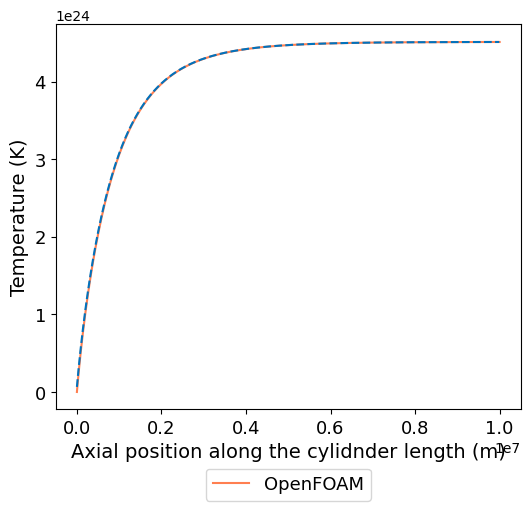

In [7]:
full_order= pd.read_csv('../0. full order/Sensitivity/10Layers_5Refine_0.75Transition_4Center.csv')

error = np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - reconstructed_solution[-1])/full_order['Average dC (atm/m^3)'].iloc[-1]
print(error)

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(full_order.iloc[:, 0], full_order.iloc[:, 1], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(full_order.iloc[:-1, 0],reconstructed_solution , '--',label = '', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)
